# Show Mesh Geometry

Plot the cell area and geometry for the uniform and stretched meshes in LFRic-Atmosphere.

In [1]:
from pathlib import Path

import cartopy.crs as ccrs
import geovista as gv
import pyvista as pv
import swiftascmaps
from aeolus.coord import isel
from aeolus.lfric import load_lfric_raw
from aeolus.model import lfric
from aeolus.plot import subplot_label_generator

pv.global_theme.trame.server_proxy_enabled = True
pv.set_jupyter_backend("trame")

import paths
from common import SIMULATIONS
from gv_lfric_utils import cube2d_to_mesh, load_lfric_mesh, mesh_to_gv_mesh

In [2]:
show_sim = ["c192", "c192s10"]

In [3]:
clim = {
    "c192": [39, 47],
    "c192s10": [4.7, 470],
}

## Load the data

In [4]:
dset = {}
for sim_label in show_sim:
    dset[sim_label] = {}
    dset[sim_label]["cell_area"] = load_lfric_raw(
        paths.data_raw
        / SIMULATIONS[sim_label]["long_name"]
        / "1"
        / "run_lfric_atm_*"
        / "lfric_initial.nc",
    ).extract_cube("cell_area")

    dset[sim_label]["mg_meshes"] = {}

    for var_name in ["dynamics", "multigrid_l1", "multigrid_l2", "multigrid_l3"]:
        dset[sim_label]["mg_meshes"][var_name] = load_lfric_mesh(
            str(
                paths.data_raw
                / SIMULATIONS[sim_label]["long_name"]
                / "1"
                / "run_lfric_atm_*"
                / "mesh_*.nc"
            ),
            var_name=var_name,
        )

    # dset[sim_label]["inst_diag"] = load_lfric_raw(
    #     paths.data_raw
    #     / SIMULATIONS[sim_label]["long_name"]
    #     / "30"
    #     / "run_lfric_atm_*"
    #     / "lfric_inst_diag.nc",
    #     drop_coord=["forecast_reference_time"],
    # )
# for i, cube in enumerate(dset[sim_label]["inst_diag"]):
#     print(f"---|---|-{'-'*30}-|-{'-'*60}")
#     print(f"{i:<2d} | {cube.ndim} | {cube.var_name:>30} | {cube.name():>60}")

## Calculate additional diagnostics and create geovista meshes

In [5]:
# Convert cell area to the cell width by taking a square root

for sim_label in show_sim:
    dset[sim_label]["cell_width"] = dset[sim_label]["cell_area"] ** 0.5
    dset[sim_label]["cell_width"].convert_units("km")
    dset[sim_label]["cell_width"].rename("grid_cell_width")
    dset[sim_label]["cell_width"].attributes.pop("invalid_standard_name")

In [6]:
gv_meshes = {}
for sim_label in show_sim:
    gv_meshes[sim_label] = {}
    gv_meshes[sim_label]["cell_width"] = cube2d_to_mesh(dset[sim_label]["cell_width"])

    for var_name in dset[sim_label]["mg_meshes"]:
        gv_meshes[sim_label][var_name] = mesh_to_gv_mesh(
            dset[sim_label]["mg_meshes"][var_name]
        )

## Assemble the figure

### Robinson projection

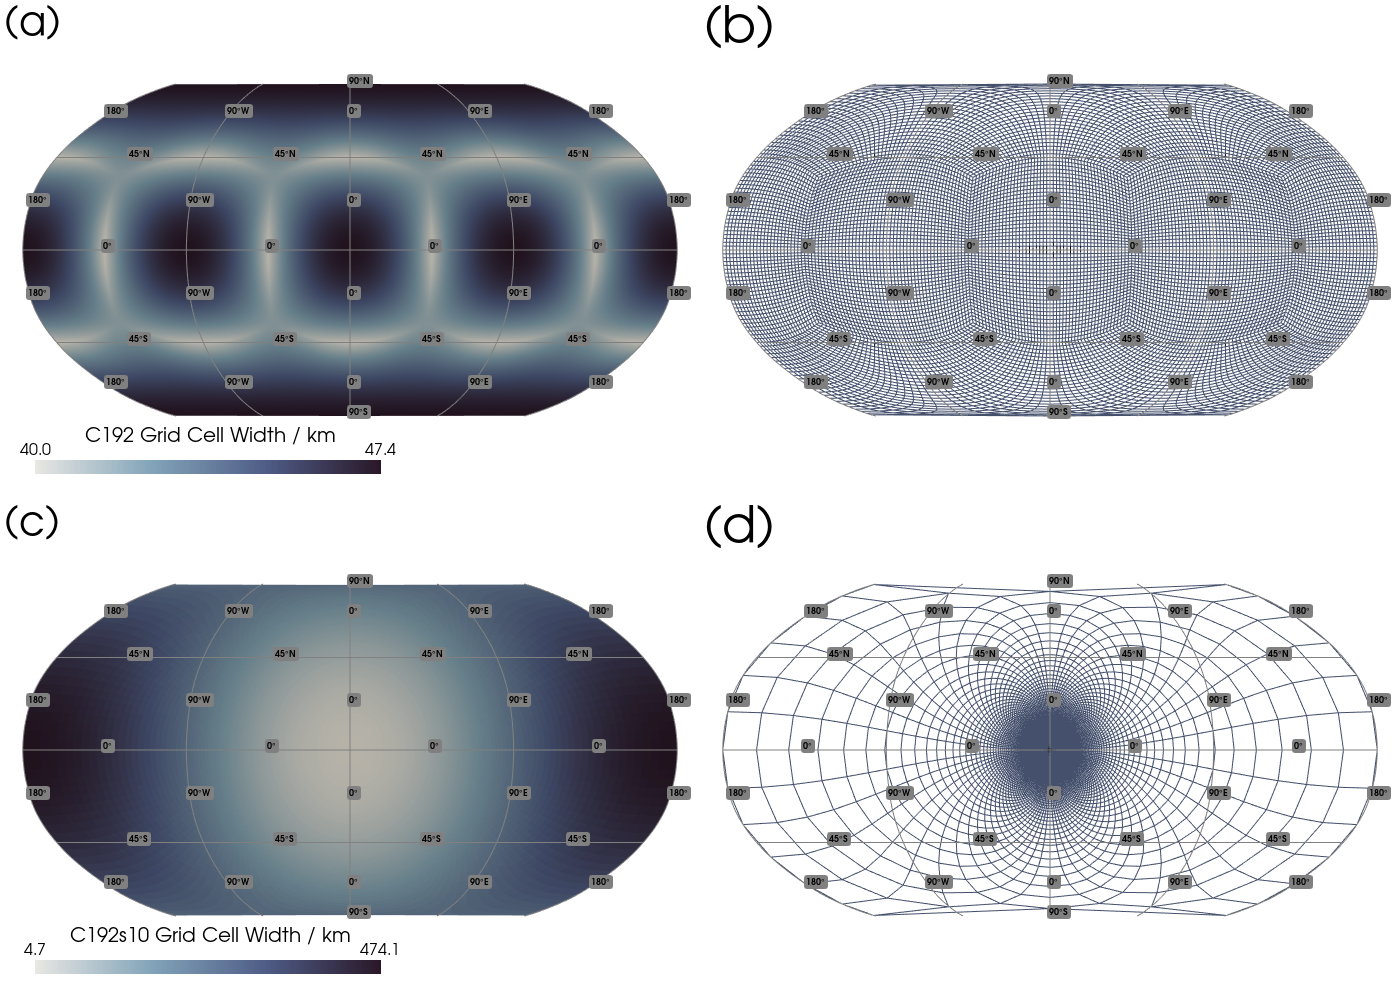

In [7]:
plotter = gv.GeoPlotter(
    window_size=[1400, 1000], crs=ccrs.Robinson(), shape=(2, 2), border=False
)
zoom = 1.5
kw_grat = dict(lon_step=90, lat_step=45, mesh_args={"color": "grey"})
letters = subplot_label_generator()

for sim_idx, sim_label in enumerate(show_sim):
    plotter.subplot(sim_idx, 0)
    plotter.add_text(
        f"({next(letters)})",
        position="upper_left",
        font_size=16,
    )
    plotter.add_mesh(
        gv_meshes[sim_label]["cell_width"].copy(),
        # clim=clim[sim_label],
        cmap=swiftascmaps.midnights_r,
        show_scalar_bar=True,
        zlevel=0,
        scalar_bar_args={
            "title": f"{SIMULATIONS[sim_label]['title']} Grid Cell Width / km",
            "title_font_size": 20,
            "label_font_size": 16,
            "shadow": False,
            "n_labels": 2,
            "italic": False,
            "fmt": "%.1f",
            "font_family": "arial",
            "width": 0.5,
            "vertical": False,
            "position_x": 0.05,
            "position_y": 0.05,
        },
    )
    plotter.add_graticule(**kw_grat)
    plotter.view_xy()
    plotter.camera.zoom(zoom)

    plotter.subplot(sim_idx, 1)
    plotter.add_text(
        f"({next(letters)})",
        position="upper_left",
        font_size=20,
    )
    plotter.add_mesh(
        gv_meshes[sim_label]["multigrid_l2"],
        style="wireframe",
        color="#586891",
        line_width=0.01,
    )
    plotter.add_graticule(**kw_grat)
    plotter.view_xy()
    plotter.camera.zoom(zoom)


plotter.show(jupyter_backend="static")

plotter.screenshot(
    paths.figures
    / f"{'_'.join(SIMULATIONS[sim_label]['long_name'] for sim_label in show_sim)}__cell_geometry"
);